# Imports

In [85]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

# Preprocessing

In [86]:
df = pd.read_csv("logs.csv", sep=",")

df["Door_wide_open"] = df["Door"]=="open"
df["Door_ajar"] = df["Door"]=="ajar"
df.drop(columns=["Door"], axis=1, inplace=True)
df["t"] = pd.to_datetime(df["t"], format="mixed")

df["Alarm level"] = df["Alarm level"].map(lambda x: int(x[:1]))
df = df.dropna()

In [87]:
#filtered_df = df.loc[(df['t'] >= '2025-10-25 12') & (df['t'] < '2025-10-25 13')]
#filtered_df_cp = filtered_df.copy()
#filtered_df_cp["Door_ajar"] = np.where(filtered_df["Door_ajar"] & (filtered_df["Alarm level"] > 2), 1, 0) # filter for slightly open door and alarm level (repeated measurements)



# General statistics
## openings per day

In [93]:
def get_df_opening_per_day(df: pd.DataFrame) -> pd.DataFrame:
    df = df[["t", "Door_wide_open"]].copy()
    idx = np.where(
        np.all(np.lib.stride_tricks.sliding_window_view(df["Door_wide_open"].copy(), 2) == [0,1], axis=1)
    )[0] + 1
    beginnings = np.zeros((len(df)))
    beginnings[idx] = 1
    df["Door_wide_open_start"] = beginnings
    return df


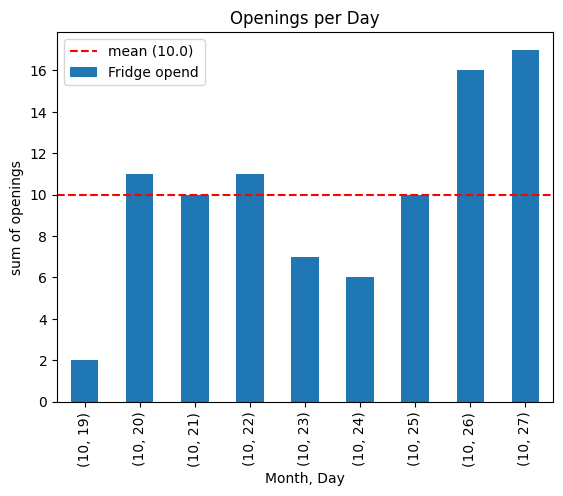

In [94]:
def plot_hist_opens(df : pd.DataFrame, mode : str):
    if mode == "dm":
        df["t"] = df["t"].apply(lambda t: (t.month, t.day))
    elif mode =="d":
        df["t"] = df["t"].apply(lambda t: t.day)

    df_grouped = df.groupby("t")["Door_wide_open_start"].sum()

    df_grouped.plot(kind="bar", label="Fridge opend")
    plt.xlabel("Month, Day") if mode == "dm" else plt.xlabel("Day")
    plt.ylabel("sum of openings")
    plt.title("Openings per Day")
    plt.axhline(df_grouped.mean(), linestyle="--", color="r", label= f"mean ({round(df_grouped.mean(),1)})")
    plt.legend()
    plt.show()

plot_hist_opens(get_df_opening_per_day(df.copy()), "dm")

## ajar door

In [112]:
def get_df_door_ajar(df: pd.DataFrame) -> pd.DataFrame:
    df = df[["t" ,"Door_ajar", "Alarm level"]].copy()

    df["Door_ajar"] = np.where(df["Door_ajar"] & (df["Alarm level"] > 2), 1, 0) # filter for slightly open door and alarm level (repeated measurements)

    # find beginnings (find all [0,1] occurrences)
    idx = np.where(
        np.all(np.lib.stride_tricks.sliding_window_view(df["Door_ajar"].copy(), 2) == [0,1], axis=1)
    )[0] + 1 # +1 so that we don't find the 0s

    beginnings = np.zeros((len(df)))
    beginnings[idx] = 1
    df["Door_ajar_start"] = beginnings.astype(int)
    return df


### Plot

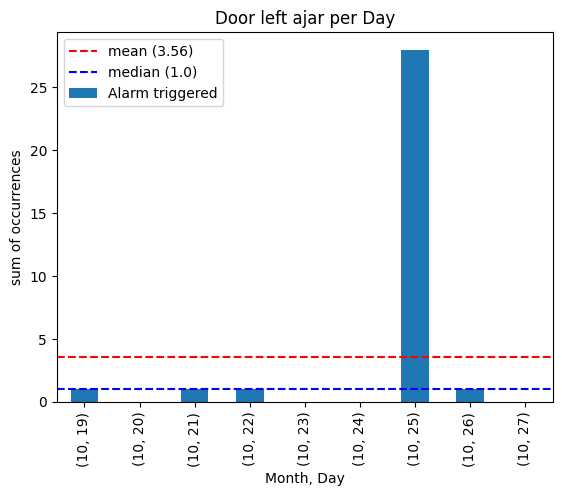

Total times alarm was triggered because door was slightly left open: 32


In [113]:
def plot_hist_ajars(df: pd.DataFrame, mode : str):
    df["t"] = df["t"].apply(lambda t: (t.month, t.day))
    df_grouped = df.groupby("t")["Door_ajar_start"].sum()

    df_grouped.plot(kind="bar", label="Alarm triggered")
    plt.xlabel("Month, Day")
    plt.ylabel("sum of occurrences")
    plt.title("Door left ajar per Day")
    plt.axhline(df_grouped.mean(), linestyle="--", color="r", label=f"mean ({round(df_grouped.mean(), 2)})")
    plt.axhline(df_grouped.median(), linestyle="--", color="b", label=f"median ({round(df_grouped.median(), 2)})")
    plt.legend()
    plt.show()
    print("Total times alarm was triggered because door was slightly left open:", sum(df["Door_ajar_start"]))

plot_hist_ajars(get_df_door_ajar(df.copy()), "d")

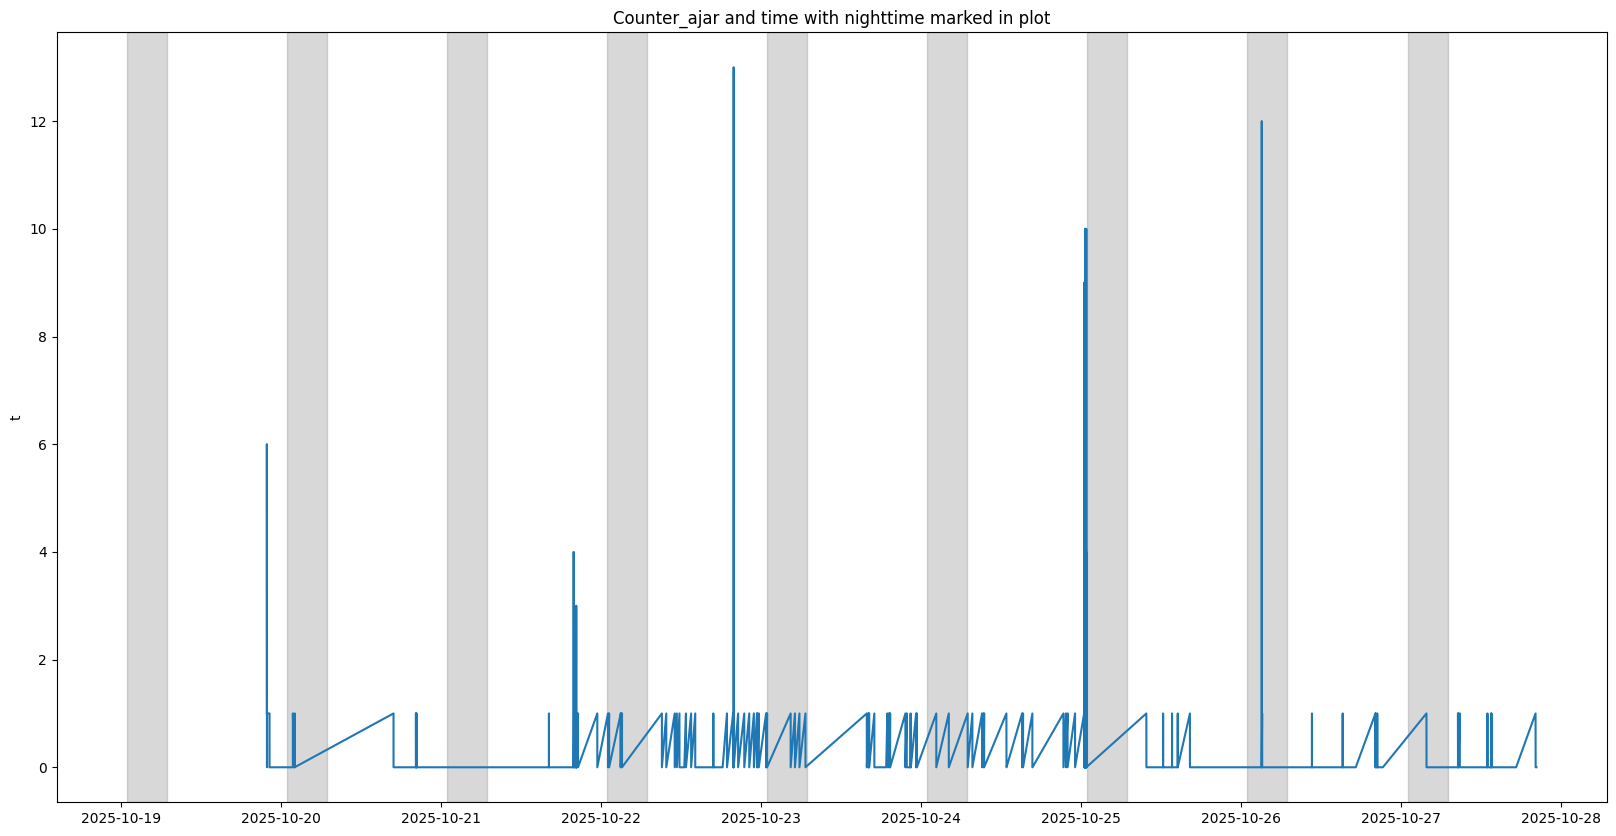

In [114]:
def plot_todo_find_name(df : pd.DataFrame):
    df = df[["t" ,"Door_ajar", "Alarm level", "Counter_ajar", "Dist"]]
    #df = df.loc[(df['t'] >= '2025-10-23') & (df['t'] < '2025-10-26')]
    # todo filter for ajar
    plt.figure(figsize=(20,10))
    plt.plot(df["t"], df["Counter_ajar"])

    for day in df['t'].dt.date.unique():
        start = pd.Timestamp(f"{day} 01:00")
        end = pd.Timestamp(f"{day} 07:00")
        plt.axvspan(start, end, color='gray', alpha=0.3)

    plt.ylabel("Counter_ajar")
    plt.ylabel("t")
    plt.title("Counter_ajar and time with nighttime marked in plot")
    #plt.axhline(tmp.mean(), linestyle="--", color="r", label=f"mean ({round(tmp.mean(), 2)})")
    plt.show()
plot_todo_find_name(df.copy())

## Plot open door

In [116]:
def get_df_door_open(df: pd.DataFrame) -> pd.DataFrame:
    df = df[["t" ,"Door_wide_open", "Alarm level"]].copy()
    df["Door_left_wide_open"] = np.where(df["Door_wide_open"] & (df["Alarm level"] > 0), 1, 0)
    idx = np.where(
        np.all(np.lib.stride_tricks.sliding_window_view(df["Door_left_wide_open"].copy(), 2) == [0,1], axis=1)
    )[0] + 1 # +1 so that we don't find the 0s

    beginnings = np.zeros((len(df)))
    beginnings[idx] = 1
    df["Door_left_wide_open_start"] = beginnings.astype(int)

    return df

# plot

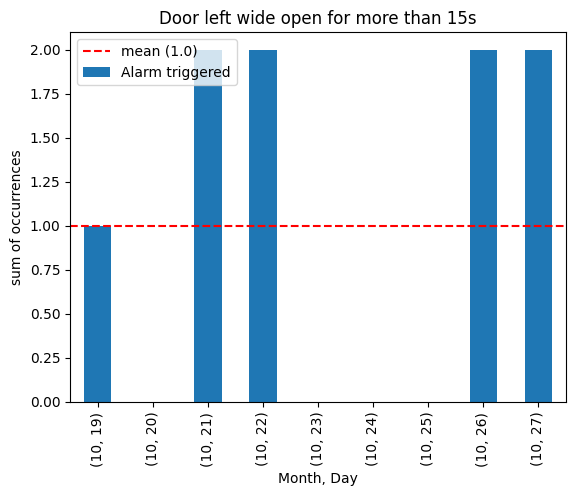

Total times alarm was triggered because door was left open: 9


In [119]:
def plot_door_open(df: pd.DataFrame):
    df["t"] = df["t"].apply(lambda t: (t.month, t.day))
    df_grouped = df.groupby("t")["Door_left_wide_open_start"].sum()

    df_grouped.plot(kind="bar", label="Alarm triggered")
    plt.xlabel("Month, Day")
    plt.ylabel("sum of occurrences")
    plt.title("Door left wide open for more than 15s")
    plt.axhline(df_grouped.mean(), linestyle="--", color="r", label=f"mean ({round(df_grouped.mean(), 2)})")
    plt.legend()
    plt.show()
    print("Total times alarm was triggered because door was left open:", df["Door_left_wide_open_start"].sum())
plot_door_open(get_df_door_open(df.copy()))